In [1]:
pip install pandas numpy matplotlib seaborn geopandas shapely contextily scikit-learn folium

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import folium
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Updated configuration method for OSMnx 1.2+
ox.settings.log_console = True
ox.settings.use_cache = True

In [5]:
# 1. DATA LOADING
print("Loading NYC Yellow Taxi data...")
# Download taxi data if not already available
!wget -q -nc https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet -O yellow-tripdata-2023-01.parquet

# Load taxi trip data using parquet format (more efficient than CSV)
taxi_data = pd.read_parquet('yellow-tripdata-2023-01.parquet')

# Download taxi zone data if not already available
!wget -q -nc https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip -O taxi_zones.zip
!unzip -o -q taxi_zones.zip -d taxi_zones
print(f"Loaded {len(taxi_data)} taxi trips")

Loading NYC Yellow Taxi data...
Loaded 3066766 taxi trips


In [6]:
# 2. DATA EXPLORATION
print("\nDataset Info:")
print(taxi_data.info())

print("\nFirst 5 rows:")
print(taxi_data.head())

print("\nDescriptive Statistics:")
print(taxi_data.describe())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport

In [7]:
# 3. DATA PREPROCESSING
print("\nPreprocessing data...")
# Convert datetime columns
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])

# Extract time features
taxi_data['pickup_hour'] = taxi_data['tpep_pickup_datetime'].dt.hour
taxi_data['pickup_day'] = taxi_data['tpep_pickup_datetime'].dt.day
taxi_data['pickup_dayofweek'] = taxi_data['tpep_pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6
taxi_data['trip_duration'] = (taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']).dt.total_seconds() / 60  # in minutes

# Filter for Manhattan trips only (zones 1-68)
manhattan_zones = list(range(1, 69))
taxi_data = taxi_data[taxi_data['PULocationID'].isin(manhattan_zones) &
                      taxi_data['DOLocationID'].isin(manhattan_zones)]

# Remove unrealistic values
taxi_data = taxi_data[(taxi_data['trip_duration'] > 0) & (taxi_data['trip_duration'] < 180)]  # trips between 0 and 3 hours
taxi_data = taxi_data[(taxi_data['trip_distance'] > 0) & (taxi_data['trip_distance'] < 50)]  # distance between 0 and 50 miles
taxi_data = taxi_data[(taxi_data['fare_amount'] > 0) & (taxi_data['fare_amount'] < 200)]  # fare between $0 and $200

# For faster processing in development, sample the data
# Remove this line for full analysis
taxi_data = taxi_data.sample(10000, random_state=42)

print(f"After preprocessing: {len(taxi_data)} valid Manhattan trips")

# Check for missing values
print("Missing values per column:")
print(taxi_data.isnull().sum())


Preprocessing data...
After preprocessing: 10000 valid Manhattan trips
Missing values per column:
VendorID                   0
tpep_pickup_datetime       0
tpep_dropoff_datetime      0
passenger_count          252
trip_distance              0
RatecodeID               252
store_and_fwd_flag       252
PULocationID               0
DOLocationID               0
payment_type               0
fare_amount                0
extra                      0
mta_tax                    0
tip_amount                 0
tolls_amount               0
improvement_surcharge      0
total_amount               0
congestion_surcharge     252
airport_fee              252
pickup_hour                0
pickup_day                 0
pickup_dayofweek           0
trip_duration              0
dtype: int64



Generating visualizations...


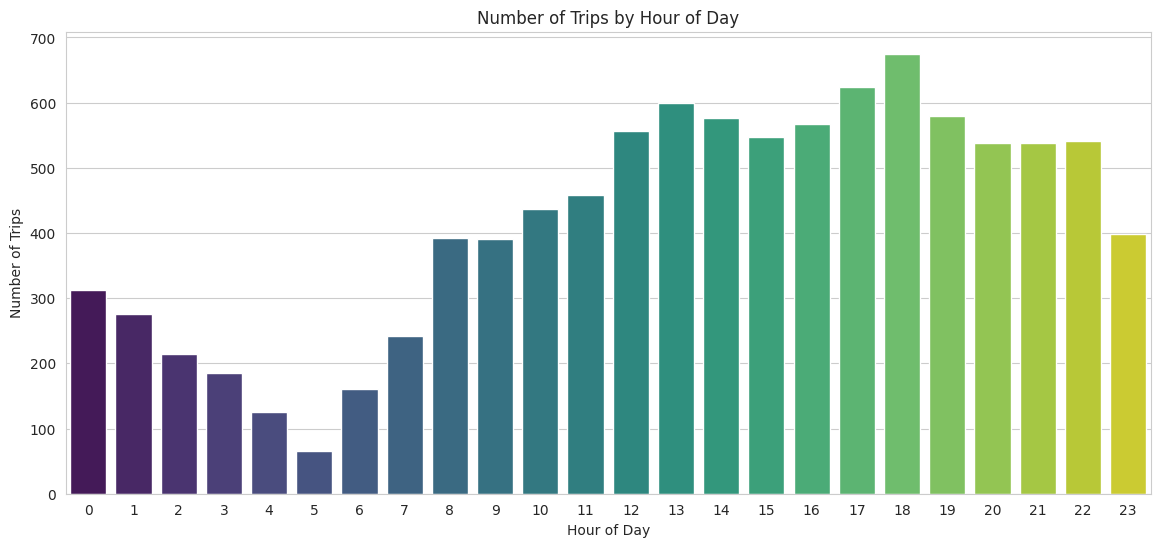

In [10]:
# 4. VISUALIZATIONS
print("\nGenerating visualizations...")
# Trip distribution by hour
plt.figure(figsize=(14, 6))
sns.countplot(x='pickup_hour', data=taxi_data, palette='viridis')
plt.title('Number of Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show('trips_by_hour.png')

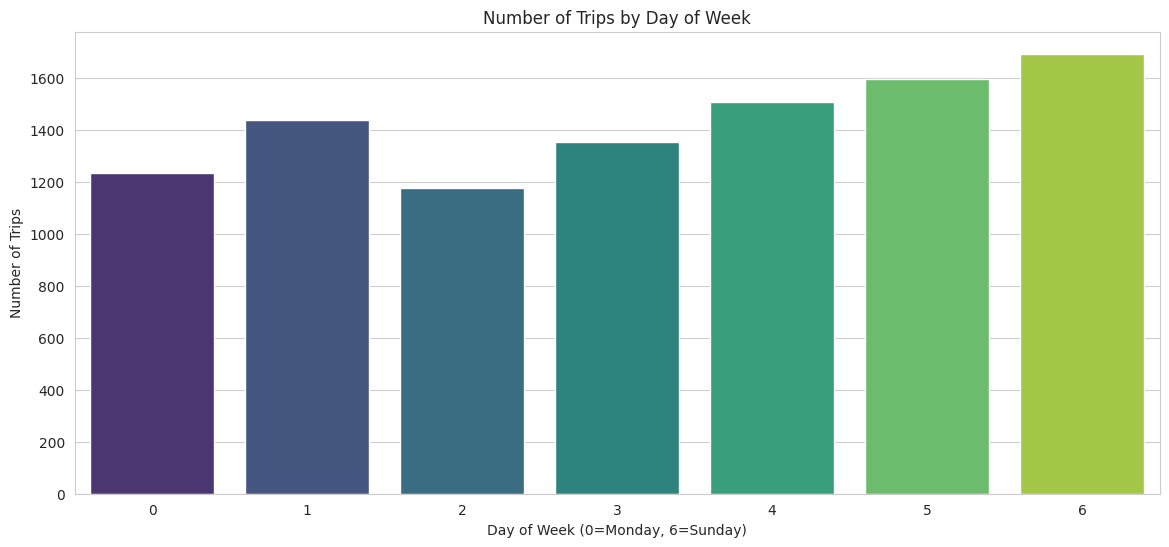

In [11]:
# Trip distribution by day of week
plt.figure(figsize=(14, 6))
sns.countplot(x='pickup_dayofweek', data=taxi_data, palette='viridis')
plt.title('Number of Trips by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Trips')
plt.show('trips_by_day.png')

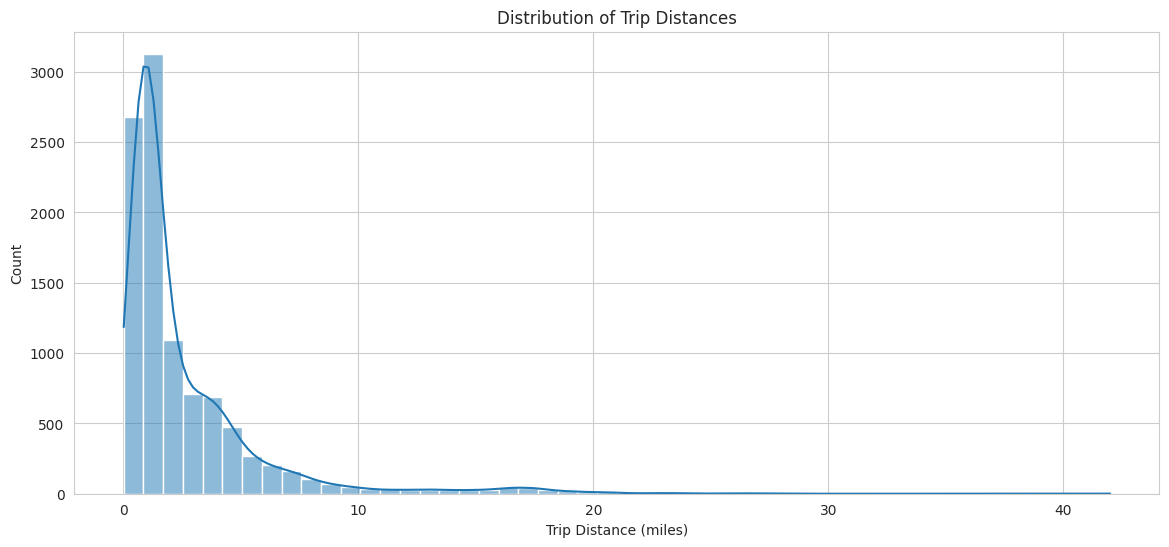

In [12]:
# Trip distance distribution
plt.figure(figsize=(14, 6))
sns.histplot(taxi_data['trip_distance'], bins=50, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.show('trip_distance_dist.png')

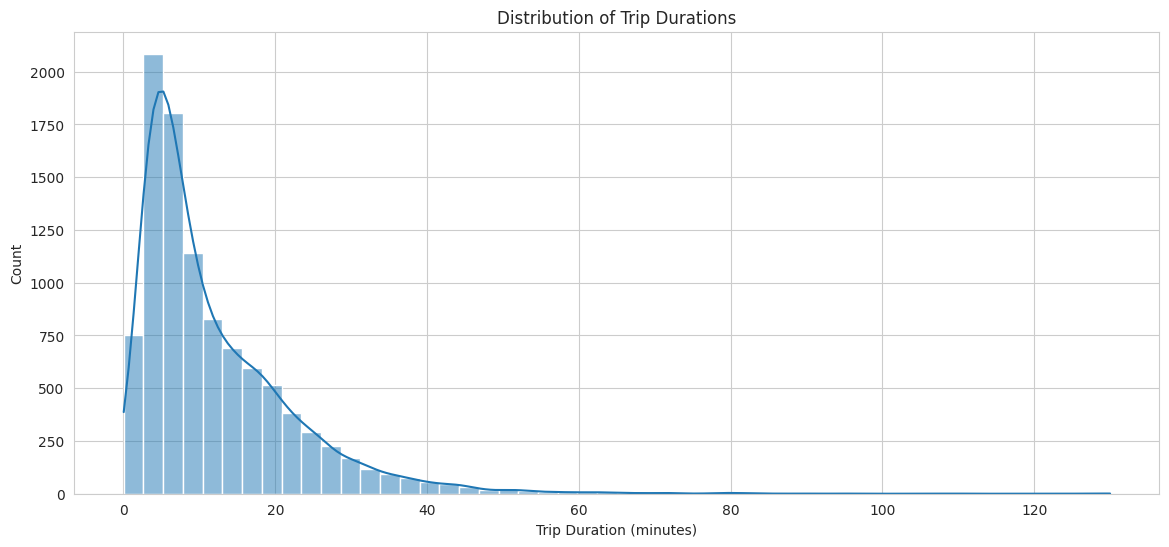

In [13]:
# Trip duration distribution
plt.figure(figsize=(14, 6))
sns.histplot(taxi_data['trip_duration'], bins=50, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Count')
plt.show('trip_duration_dist.png')


Loading geographical data...
Loaded 69 Manhattan zones


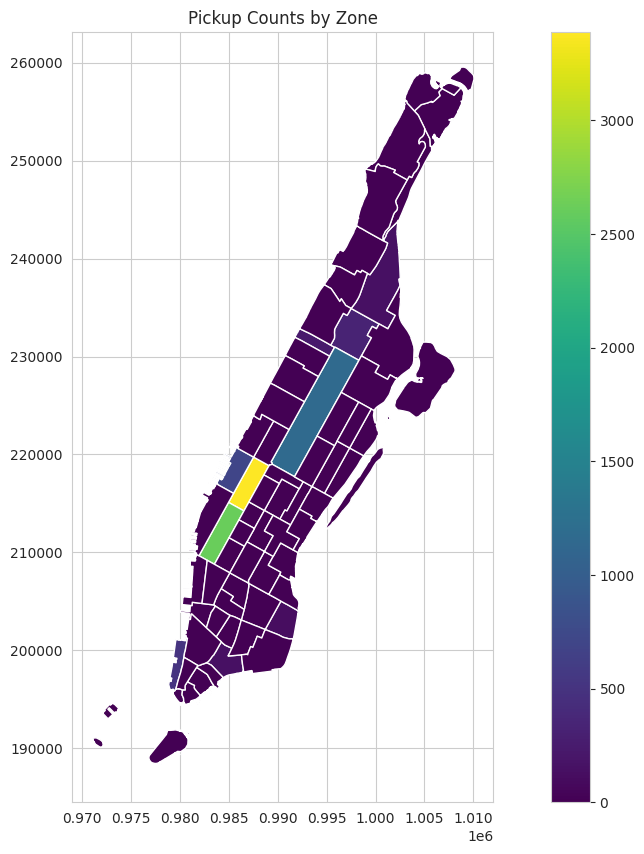

In [14]:
# 5. LOAD GEOGRAPHICAL DATA
print("\nLoading geographical data...")
# Load taxi zones shapefile
zones = gpd.read_file("taxi_zones/taxi_zones.shp")
manhattan_zones_geo = zones[zones['borough'] == 'Manhattan'].copy()
manhattan_zones_geo['centroid'] = manhattan_zones_geo.geometry.centroid
print(f"Loaded {len(manhattan_zones_geo)} Manhattan zones")

# Calculate pickup counts per zone
pickup_counts = taxi_data['PULocationID'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

# Merge with zones
manhattan_zones_geo = manhattan_zones_geo.merge(pickup_counts, left_on='LocationID', right_on='LocationID', how='left').fillna(0)

# Plot pickup counts on map
manhattan_zones_geo.plot(column='pickup_count', cmap='viridis', legend=True, figsize=(15, 10))
plt.title('Pickup Counts by Zone')
plt.show('pickup_counts_map.png')


Analyzing demand patterns...


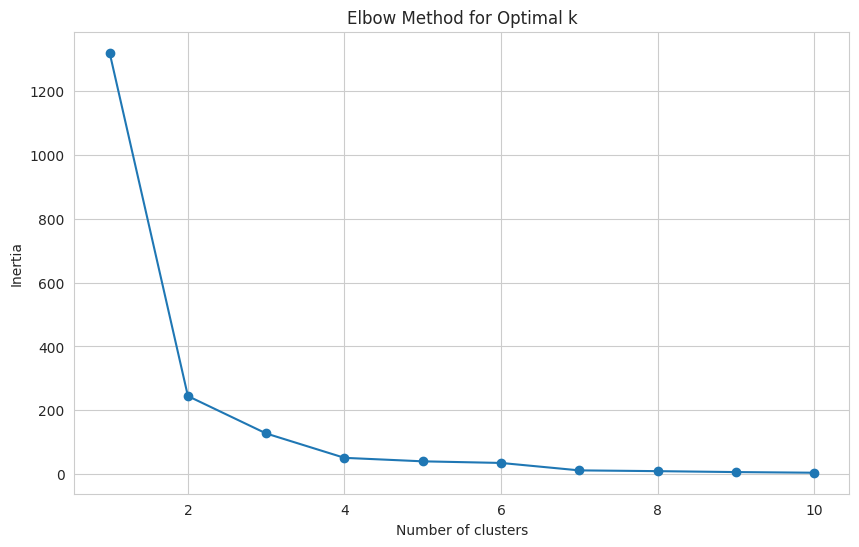

In [15]:
# 6. DEMAND ANALYSIS AND CLUSTERING
print("\nAnalyzing demand patterns...")
# Create a demand dataframe (pickups per location per hour)
demand_df = taxi_data.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='demand')

# Pivot for visualization and clustering
demand_pivot = demand_df.pivot(index='PULocationID', columns='pickup_hour', values='demand').fillna(0)

# Normalize demand for clustering
scaler = StandardScaler()
demand_scaled = scaler.fit_transform(demand_pivot)

# Find optimal number of clusters using elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(demand_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show('elbow_method.png')

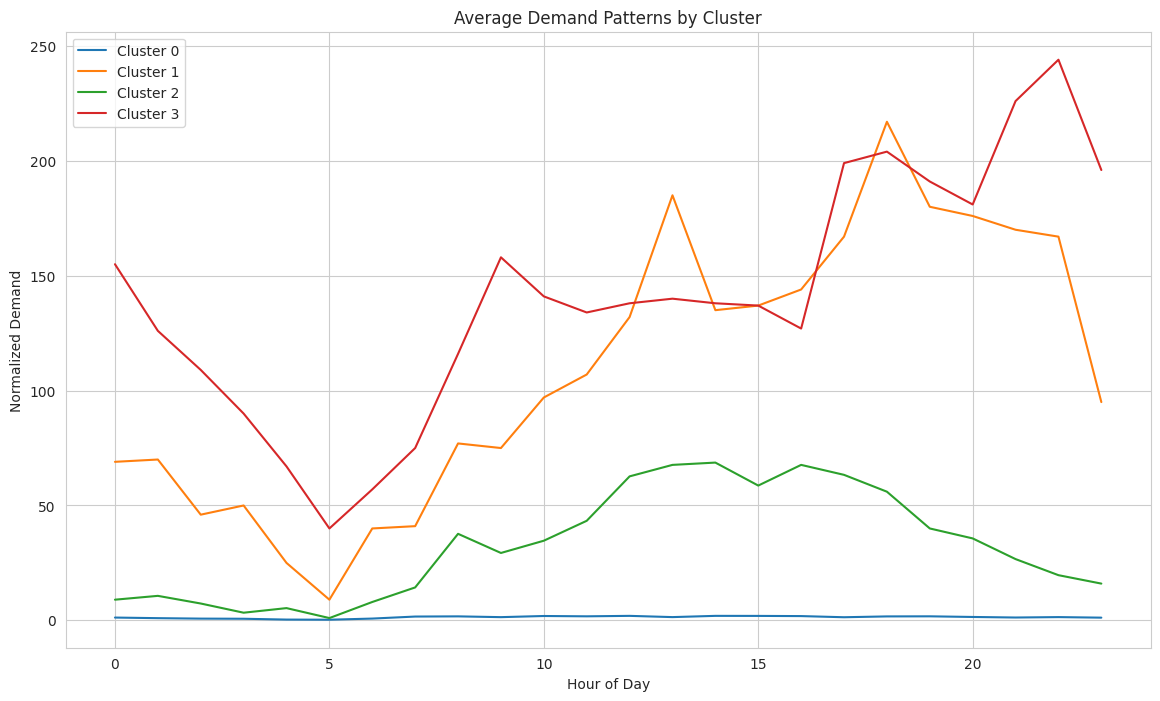

In [16]:
# Apply K-means clustering (choose k=4 based on the elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(demand_scaled)
demand_pivot['cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(14, 8))
for cluster in range(4):
    cluster_data = demand_pivot[demand_pivot['cluster'] == cluster].drop('cluster', axis=1).mean()
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}')

plt.title('Average Demand Patterns by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Demand')
plt.legend()
plt.show('demand_clusters.png')


Building road network...
Zone 4 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 12 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 13 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 24 mapped to node 246901366 at 40.7049134, -74.0173422
Zone 41 mapped to node 5871416392 at 40.8763557, -73.9076185
Zone 42 mapped to node 5871416392 at 40.8763557, -73.9076185
Zone 43 mapped to node 42431724 at 40.8778412, -73.9100278
Zone 45 mapped to node 5871416392 at 40.8763557, -73.9076185
Zone 48 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 50 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 68 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 74 mapped to node 42431724 at 40.8778412, -73.9100278
Zone 75 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 79 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 87 mapped to node 607911351 at 40.7015518, -74.0139809
Zone 88 mapped to node 42431724 at 40.8778412, -73.9100278
Zone 90 mapped 

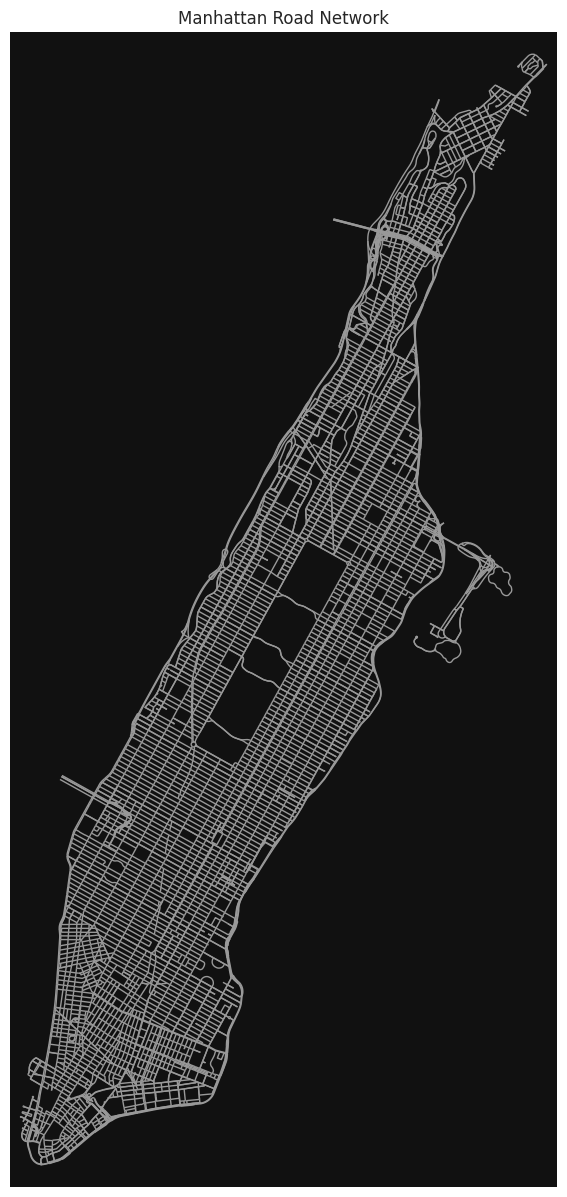

In [26]:
# 7. NETWORK ANALYSIS
print("\nBuilding road network...")
# Download and build Manhattan road network
G = ox.graph_from_place('Manhattan, NYC', network_type='drive')

# Add speed and travel time estimates
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Map zone centroids to nearest nodes in the road network
zone_nodes = {}
for _, zone in manhattan_zones_geo.iterrows():
    if pd.notna(zone['LocationID']):
        try:
            node = ox.distance.nearest_nodes(
                G,
                X=[zone['centroid'].x],
                Y=[zone['centroid'].y]
            )[0]
            zone_nodes[int(zone['LocationID'])] = node
            # Print mapping for debugging
            print(f"Zone {int(zone['LocationID'])} mapped to node {node} at {G.nodes[node]['y']}, {G.nodes[node]['x']}")
        except Exception as e:
            print(f"Error mapping zone {zone['LocationID']}: {e}")


# Plot the road network
fig, ax = ox.plot_graph(G, node_size=0, figsize=(15, 15), show=False)
plt.title('Manhattan Road Network')
plt.show('manhattan_road_network.png')

In [19]:
# 8. ROUTE OPTIMIZATION FUNCTIONS
print("\nDeveloping route optimization functions...")

def optimize_route(pickup_id, dropoff_id):
    """Find time-optimized route between two zones"""
    try:
        if pickup_id not in zone_nodes or dropoff_id not in zone_nodes:
            return None

        route = nx.shortest_path(G, zone_nodes[pickup_id], zone_nodes[dropoff_id], weight='travel_time')
        travel_time = nx.shortest_path_length(G, zone_nodes[pickup_id], zone_nodes[dropoff_id], weight='travel_time')
        return {
            'route': route,
            'time_minutes': travel_time/60,
            'path_coords': [(G.nodes[n]['y'], G.nodes[n]['x']) for n in route]
        }
    except Exception as e:
        print(f"Routing error: {e}")
        return None

def optimize_fleet_positioning(current_hour, num_vehicles=50):
    """Position autonomous taxis based on predicted demand"""
    # Get demand for the current hour
    hourly_demand = demand_df[demand_df['pickup_hour'] == current_hour]

    # Sort locations by demand
    top_demand = hourly_demand.sort_values('demand', ascending=False)

    # Get top demand locations
    top_locations = top_demand.head(num_vehicles)['PULocationID'].tolist()

    # If not enough top locations, add random ones
    if len(top_locations) < num_vehicles:
        available_locations = list(set(demand_df['PULocationID']) - set(top_locations))
        additional_needed = num_vehicles - len(top_locations)
        if available_locations and additional_needed > 0:
            additional = np.random.choice(available_locations,
                                         min(additional_needed, len(available_locations)),
                                         replace=False)
            top_locations.extend(additional)

    return top_locations


Developing route optimization functions...


In [20]:
# 9. TRIP DURATION PREDICTION MODEL
print("\nTraining trip duration prediction model...")
# Prepare data for trip duration prediction
X = taxi_data[['PULocationID', 'DOLocationID', 'pickup_hour', 'pickup_dayofweek',
              'trip_distance', 'passenger_count']]
y = taxi_data['trip_duration']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['PULocationID', 'DOLocationID'], drop_first=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f} minutes")
print(f"R2 Score: {r2:.2f}")



Training trip duration prediction model...
RMSE: 6.10 minutes
R2 Score: 0.68


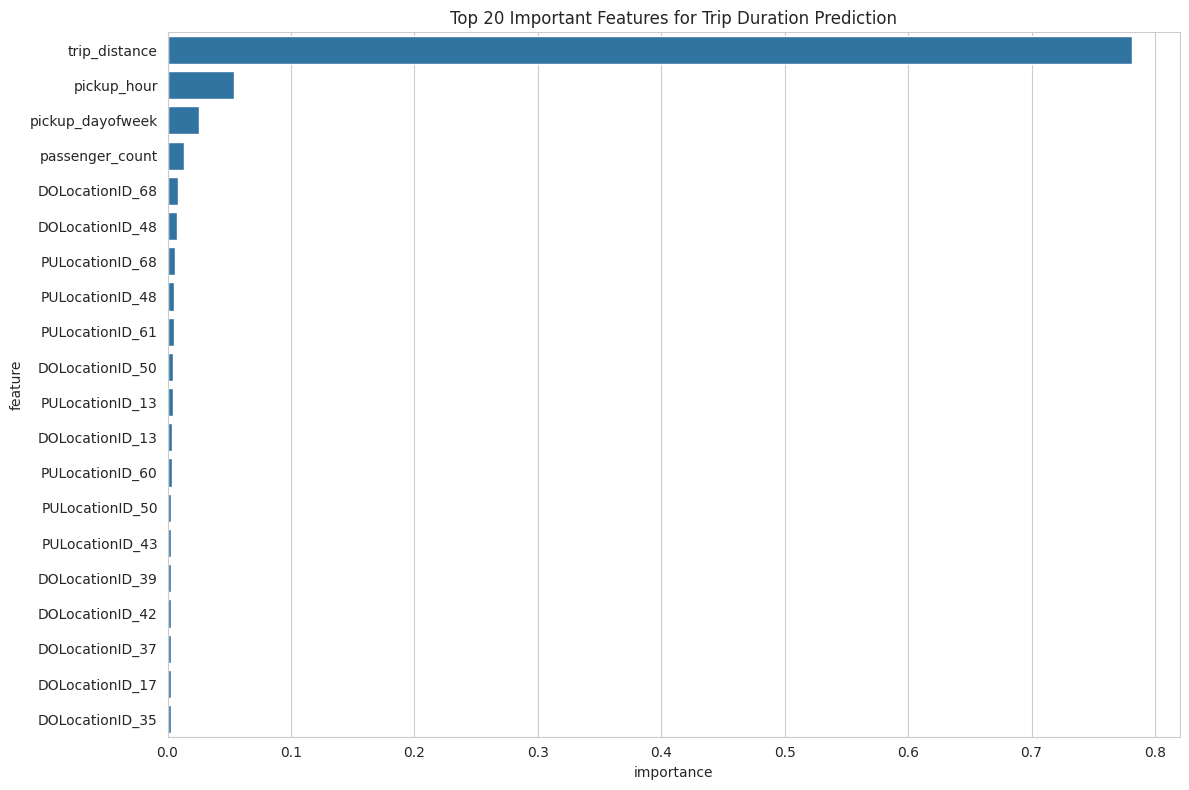

In [21]:
# Feature importance
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Important Features for Trip Duration Prediction')
plt.tight_layout()
plt.show('feature_importance.png')


Demonstrating route optimization...
Sample trip: From zone 68 to zone 48
Optimized route takes 0.0 minutes


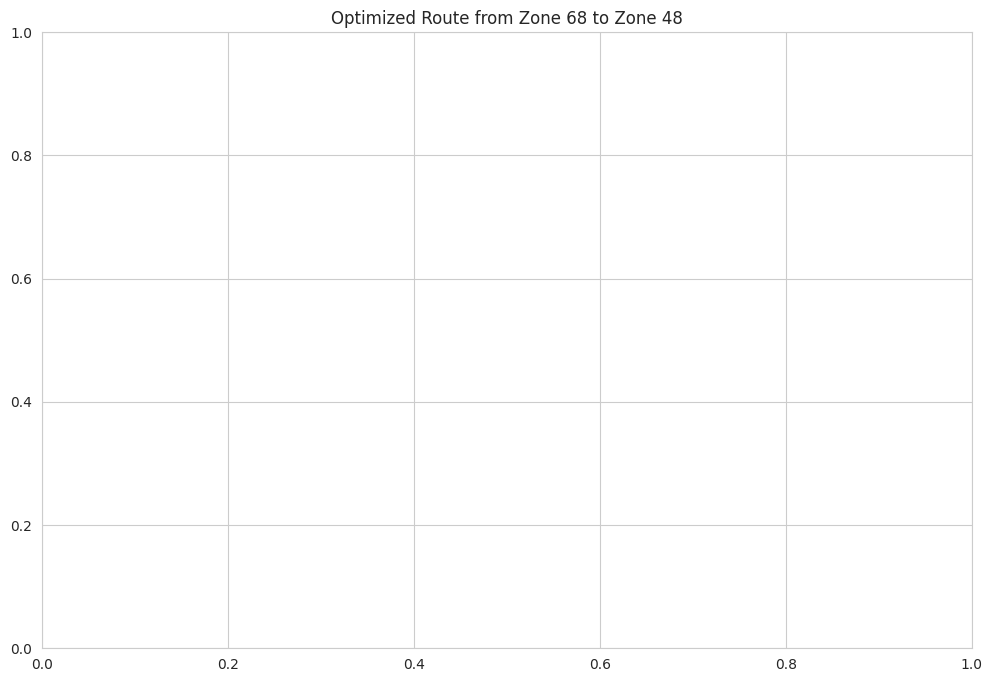

In [23]:
# 10. DEMONSTRATION OF ROUTE OPTIMIZATION
print("\nDemonstrating route optimization...")
# Sample trip for demonstration
sample_trip = taxi_data.iloc[0]
print(f"Sample trip: From zone {sample_trip['PULocationID']} to zone {sample_trip['DOLocationID']}")

# Optimize route for the sample trip
result = optimize_route(sample_trip['PULocationID'], sample_trip['DOLocationID'])

if result:
    print(f"Optimized route takes {result['time_minutes']:.1f} minutes")
    # Plot the optimized route
    fig, ax = ox.plot_graph_route(G, result['route'], route_linewidth=6, node_size=0, figsize=(15, 15), show=False)
    plt.title(f'Optimized Route from Zone {sample_trip["PULocationID"]} to Zone {sample_trip["DOLocationID"]}')
    plt.show('optimized_route.png')

In [25]:
# 11. INTERACTIVE MAP VISUALIZATION
print("\nCreating interactive map visualization...")
# Create a folium map centered at Manhattan
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)

# Add a heatmap of pickup locations
heat_data = []
for _, zone in manhattan_zones_geo.iterrows():
    if zone['pickup_count'] > 0 and not zone['centroid'].is_empty:
        heat_data.append([zone['centroid'].y, zone['centroid'].x, zone['pickup_count']])

HeatMap(heat_data, radius=15).add_to(m)

# Add optimal positions for taxis at 8 AM
optimal_positions_8am = optimize_fleet_positioning(8, num_vehicles=30)
for location_id in optimal_positions_8am:
    if location_id in zone_nodes:
        node = zone_nodes[location_id]
        node_y, node_x = G.nodes[node]['y'], G.nodes[node]['x']
        folium.Marker(
            [node_y, node_x],
            popup=f"Optimal Position: Zone {location_id}",
            icon=folium.Icon(color='green', icon='car', prefix='fa')
        ).add_to(m)

# Save the interactive map
m.save('taxi_optimization_map.html')


Creating interactive map visualization...
